# Basic examples

In this notebook we will show how to compute Lagrangian "lognormal" mocks, and apply a cutsky geometry.

In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt

from mockfactory import (EulerianLinearMock, LagrangianLinearMock,
                         Catalog, BoxCatalog, RandomBoxCatalog, box_to_cutsky,
                         DistanceToRedshift, TabulatedRadialMask, HealpixAngularMask,
                         utils, setup_logging)
# For cosmoprimo installation instructions, see https://cosmoprimo.readthedocs.io/en/latest/user/building.html
from cosmoprimo.fiducial import DESI

# Set up logging
setup_logging()
z = 1.
# Load DESI fiducial cosmology
cosmo = DESI()
power = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
f = cosmo.sigma8_z(z=z, of='theta_cb') / cosmo.sigma8_z(z=z, of='delta_cb') # growth rate
dist = cosmo.comoving_radial_distance(z)

## Eulerian mock in box

In [2]:
bias, nbar, nmesh, boxsize = 2.0, 1e-3, 256, 1000.
boxcenter = [dist, 0, 0]
mock = EulerianLinearMock(power, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=42, unitary_amplitude=False)
mock.set_real_delta_field(bias=bias)
# mesh is mock.mesh_delta_r
mesh_real = mock.mesh_delta_r.copy()
mock.set_rsd(f=f, los=None)
mesh_rsd = mock.mesh_delta_r

[000003.40] [0/1] 09-26 23:54  EulerianLinearMock        INFO     White noise generated.


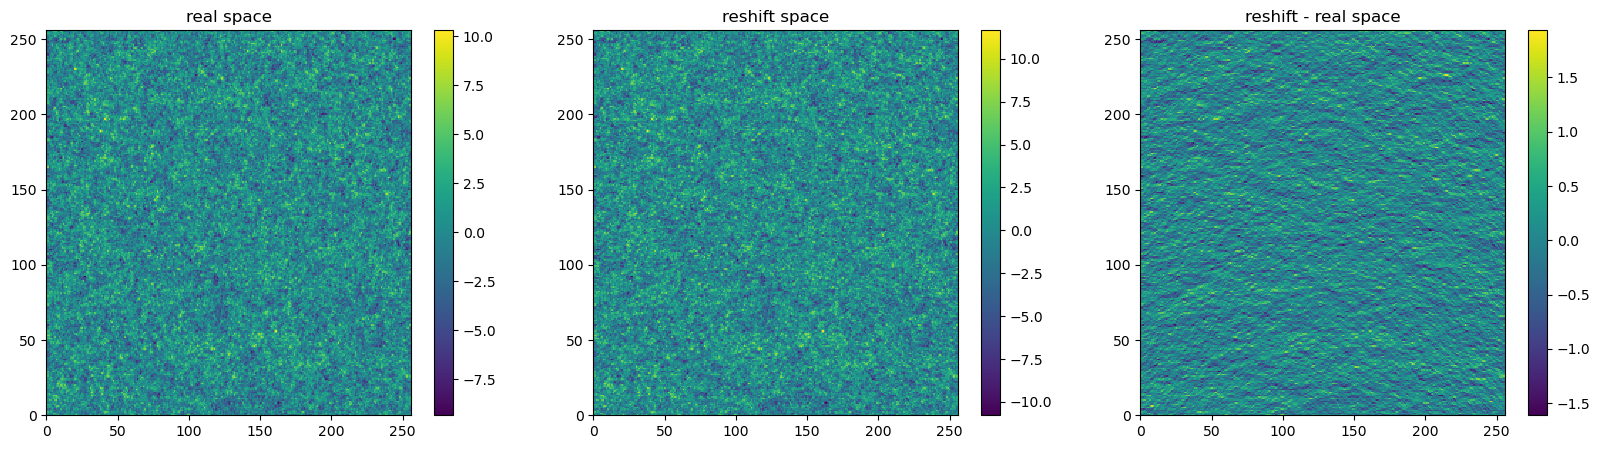

In [3]:
iz = nmesh//2
fig, lax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
lax = lax.flatten()
lax[0].set_title('real space')
c = lax[0].pcolor(mesh_real[:, :, iz])
fig.colorbar(c, ax=lax[0])
lax[1].set_title('reshift space')
c = lax[1].pcolor(mesh_rsd[:, :, iz])
fig.colorbar(c, ax=lax[1])
lax[2].set_title('reshift - real space')
c = lax[2].pcolor(mesh_rsd[:, :, iz] - mesh_real[:, :, iz])
fig.colorbar(c, ax=lax[2])
plt.show()

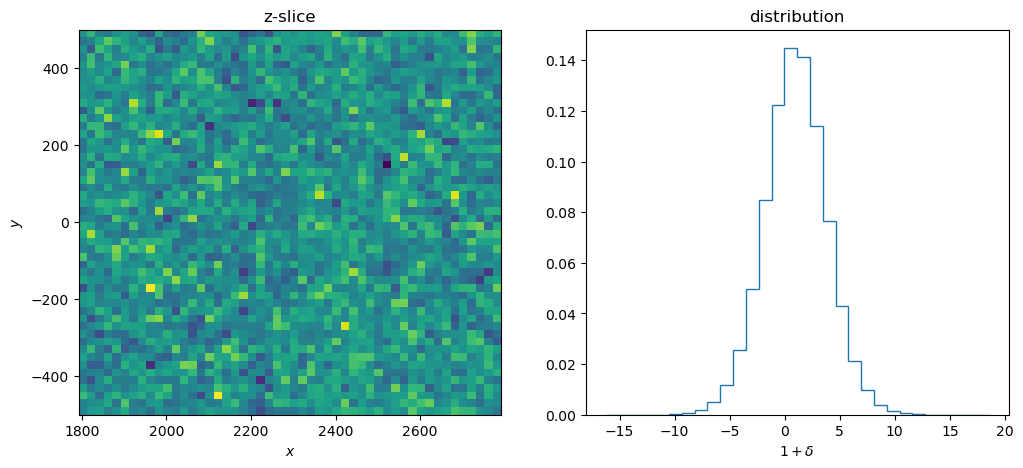

In [4]:
# Let's sample our field
data = RandomBoxCatalog(nbar=nbar, boxsize=boxsize, boxcenter=boxcenter, seed=44)
randoms = RandomBoxCatalog(nbar=4. * nbar, boxsize=boxsize, boxcenter=boxcenter, seed=45)

data['Weight'] = mock.readout(data['Position'], field='delta', resampler='cic', compensate=True) + 1.
fig, lax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
lax = lax.flatten()
width = 30
mask = (data['Position'][..., 2] >= mock.boxsize[2] / 2 - width) & (data['Position'][..., 2] <= mock.boxsize[2] / 2 + width)
lax[0].set_title('z-slice')
lax[0].hist2d(data['Position'][mask, 0], data['Position'][mask, 1], weights=data['Weight'][mask], bins=50)
lax[0].set_xlabel('$x$')
lax[0].set_ylabel('$y$')
lax[1].set_title('distribution')
lax[1].hist(data['Weight'], bins=30, density=True, histtype='step')
lax[1].set_xlabel(r'$1 + \delta$')
plt.show()

## Lognormal mock in box

In [5]:
bias, nbar, nmesh, boxsize = 2.0, 1e-3, 256, 1000.
boxcenter = [dist, 0, 0]
mock = LagrangianLinearMock(power, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=42, unitary_amplitude=False)
# This is Lagrangian bias, Eulerian bias - 1
mock.set_real_delta_field(bias=bias-1)
mock.set_analytic_selection_function(nbar=nbar)
mock.poisson_sample(seed=43)
#mock.set_rsd(f=f, los=None)
data = mock.to_catalog()

# We've got data, now turn to randoms
randoms = RandomBoxCatalog(nbar=4. * nbar, boxsize=boxsize, seed=44)

[000011.47] [0/1] 09-26 23:54  LagrangianLinearMock      INFO     White noise generated.
[000013.82] [0/1] 09-26 23:54  LagrangianLinearMock      INFO     Poisson sampling done, total number of objects is 999642.
[000015.06] [0/1] 09-26 23:54  LagrangianLinearMock      INFO     Catalog produced. Assigning in cell shift.


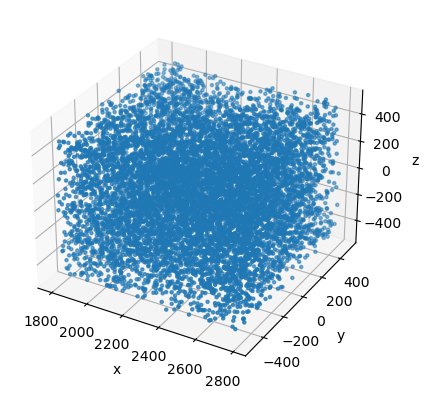

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*data['Position'][::100].T, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

## Write / Read

In [7]:
# One can save the catalog, and reload it
base_dir = '_tests'
fn = os.path.join(base_dir,'tmp.fits')
data.write(fn)
# We need to provide back everything BoxCatalog needs
data2 = BoxCatalog.read(fn, boxsize=boxsize, boxcenter=boxcenter, position='Position', velocity='Displacement')
assert np.allclose(data2.velocity, data.velocity)

[000016.53] [0/1] 09-26 23:54  FitsFile                  INFO     Writing _tests/tmp.fits.
[000016.74] [0/1] 09-26 23:54  FitsFile                  INFO     Reading _tests/tmp.fits.


## Cutsky geometry

Choosing distance, RA, Dec ranges [1821.45 - 2792.01], [0.00 - 20.63], [-10.32 - 10.32].


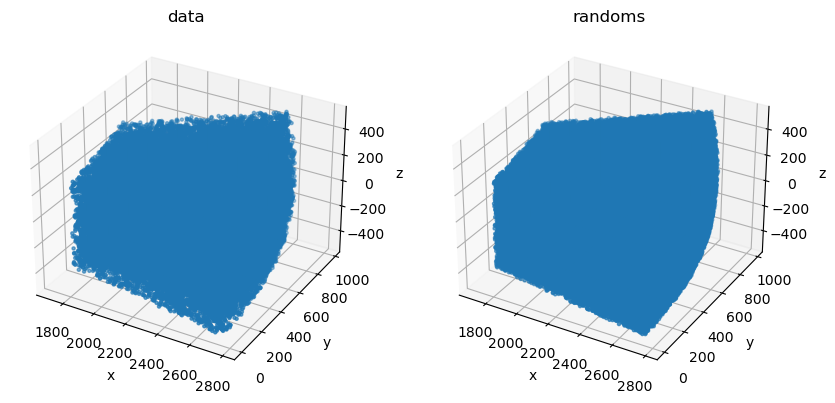

In [8]:
# Let us cut the above box to some geometry
# Let us pick the largest (RA, Dec) range we can achieve for a maximum distance of dist + boxsize / 2.
drange, rarange, decrange = box_to_cutsky(boxsize=boxsize, dmax=dist + boxsize / 2.)
# Moving RA - range to positive values, just for better display
rarange = np.array(rarange) + np.abs(np.min(rarange))
print('Choosing distance, RA, Dec ranges [{:.2f} - {:.2f}], [{:.2f} - {:.2f}], [{:.2f} - {:.2f}].'.format(*drange, *rarange, *decrange))
# noutput = None will cut as many catalogs as possible
randoms_cutsky = randoms.cutsky(drange=drange, rarange=rarange, decrange=decrange, noutput=1)

# Returned isometry corresponds to a displacement of the box along the x-axis to match drange, then a rotation to match rarange and decrange
isometry, mask_radial, mask_angular = data.isometry_for_cutsky(drange=drange, rarange=rarange, decrange=decrange)

# You can also apply any N pi/2 rotation to the box beforehand
# e.g. the average of redshift-space 2pcf of mocks over different lines of sight has a smaller variance (e.g. arXiv:2007.11417)
# from mockfactory import EuclideanIsometry
# isometry2 = EuclideanIsometry()
# isometry2.rotation(angle=90., axis='x')
# isometry2.extend(isometry)
# isometry = isometry2

# Move data to its final position
data_cutsky = data.cutsky_from_isometry(isometry, rdd=None)
# Apply RSD
# For LagrangianLinearMock, velocity is Zeldovich displacement, so just need to multiply by f
# If velocities are in proper km / s, f would be 1 / (a H) (1 / (100 a E) for Mpc/h units)
data_cutsky['RSDPosition'] = data_cutsky.rsd_position(f=f)
data_cutsky['Distance'], data_cutsky['RA'], data_cutsky['DEC'] = utils.cartesian_to_sky(data_cutsky['RSDPosition'])
# Apply selection function
mask = mask_radial(data_cutsky['Distance']) & mask_angular(data_cutsky['RA'], data_cutsky['DEC'])
data_cutsky = data_cutsky[mask]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection='3d', title='data')
ax.scatter(*data_cutsky['Position'][::10].T, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax = fig.add_subplot(122, projection='3d', title='randoms')
ax.scatter(*randoms_cutsky['Position'][::10].T, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

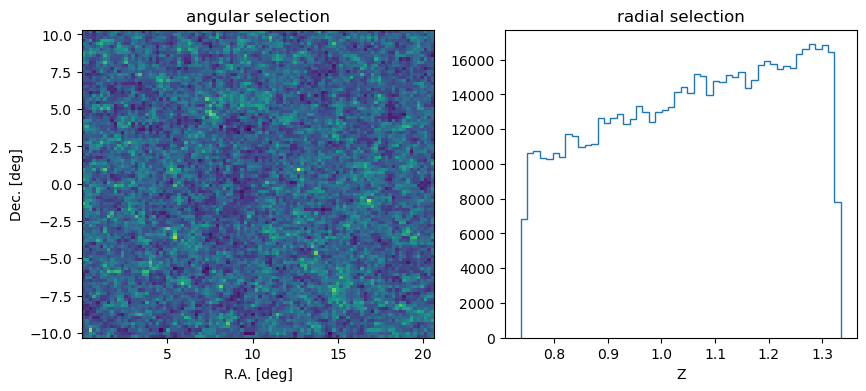

In [9]:
# Let's look at the angular and radial selection function
data_cutsky['Distance'], data_cutsky['RA'], data_cutsky['DEC'] = utils.cartesian_to_sky(data_cutsky['Position'])
distance_to_redshift = DistanceToRedshift(distance=cosmo.comoving_radial_distance)
data_cutsky['Z'] = distance_to_redshift(data_cutsky['Distance'])

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121, title='angular selection')
ax.hist2d(data_cutsky['RA'], data_cutsky['DEC'], bins=100)
ax.set_xlabel('R.A. [deg]')
ax.set_ylabel('Dec. [deg]')
ax = fig.add_subplot(122, title='radial selection')
ax.hist(data_cutsky['Z'], histtype='step', bins=50)
ax.set_xlabel('Z')
plt.show()

28.6019 % of objects will be selected


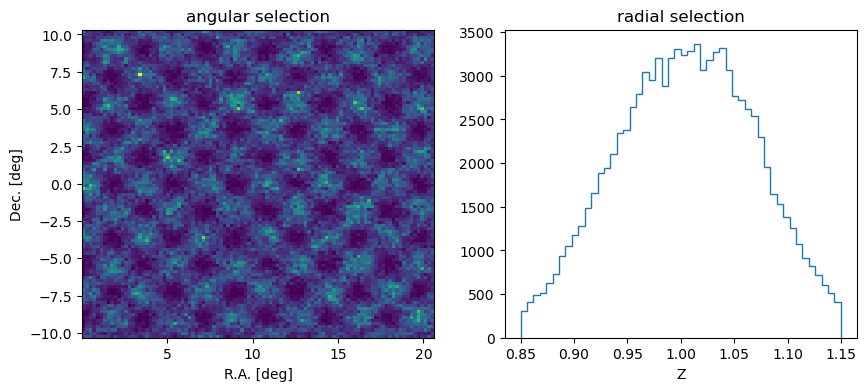

In [10]:
# Let's apply some redshift cuts
z = np.linspace(0.85, 1.15, 51)
nbar = np.exp(-200. * (z - 1.0)**2 / 2.)  # in (Mpc/h)^(-3)
mask_radial = TabulatedRadialMask(z=z, nbar=nbar)
print('{:.4f} % of objects will be selected'.format(100. * mask_radial.integral(data_cutsky['Z'])))
# And some angular cuts, e.g. healpix map
import healpy
nside = 256
theta, phi = healpy.pix2ang(nside, np.arange(healpy.nside2npix(nside)), nest=False, lonlat=False)
nbar = 1. + np.cos(100. * theta) * np.cos(100. * phi)
nbar /= nbar.max()
mask_angular = HealpixAngularMask(nbar, nest=False)
mask = mask_radial(data_cutsky['Z'], seed=84) & mask_angular(data_cutsky['RA'], data_cutsky['DEC'], seed=85)

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, title='angular selection')
ax.hist2d(data_cutsky['RA'][mask], data_cutsky['DEC'][mask], bins=100)
ax.set_xlabel('R.A. [deg]')
ax.set_ylabel('Dec. [deg]')
ax = fig.add_subplot(122, title='radial selection')
ax.hist(data_cutsky['Z'][mask], histtype='step', bins=50)
ax.set_xlabel('Z')
plt.show()

In [11]:
# Export to e.g. fits
base_dir = '_tests'
fn = os.path.join(base_dir,'tmp.fits')
data_cutsky[mask].write(fn)
# Reload
data_cutsky = Catalog.read(fn)
print(data_cutsky.columns())

[000021.23] [0/1] 09-26 23:54  FitsFile                  INFO     Writing _tests/tmp.fits.
[000021.30] [0/1] 09-26 23:54  FitsFile                  INFO     Reading _tests/tmp.fits.
['Position', 'Displacement', 'RSDPosition', 'Distance', 'RA', 'DEC', 'Z']


In [12]:
# Everything above is MPI'ed, let's write a script

In [13]:
%%file '_tests/script.py'

import os

import numpy as np

from mockfactory import (LagrangianLinearMock, RandomBoxCatalog, DistanceToRedshift, TabulatedRadialMask,
                         utils, setup_logging)
from cosmoprimo.fiducial import DESI

# Set up logging
setup_logging()
z = 1.
# Loading DESI fiducial cosmology
cosmo = DESI()
power = cosmo.get_fourier().pk_interpolator().to_1d(z=z)

dist = cosmo.comoving_radial_distance(z)
f = cosmo.sigma8_z(z=z, of='theta_cb') / cosmo.sigma8_z(z=z, of='delta_cb') # growth rate
bias, nbar, nmesh, boxsize = 2.0, 1e-3, 256, 1000.
boxcenter = [dist, 0, 0]
mock = LagrangianLinearMock(power, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=42, unitary_amplitude=False)
# this is Lagrangian bias, Eulerian bias - 1
mock.set_real_delta_field(bias=bias - 1)
mock.set_analytic_selection_function(nbar=nbar)
mock.poisson_sample(seed=43)
mock.set_rsd(f=f, los=None)
data = mock.to_catalog()

# We've got data, now turn to randoms
randoms = RandomBoxCatalog(nbar=4. * nbar, boxsize=boxsize, seed=44)

# Let us cut the above box to some geometry
drange = [dist - boxsize / 3., dist + boxsize / 3.]
rarange = [10, 20]
decrange = [20, 30]

data = data.cutsky(drange=drange, rarange=rarange, decrange=decrange)
randoms = randoms.cutsky(drange=drange, rarange=rarange, decrange=decrange)

distance_to_redshift = DistanceToRedshift(distance=cosmo.comoving_radial_distance)

for catalog in [data, randoms]:
    catalog['Distance'], catalog['RA'], catalog['DEC'] = utils.cartesian_to_sky(catalog.position)
    catalog['Z'] = distance_to_redshift(catalog['Distance'])

# Let us apply some redshift cuts
z = np.linspace(0.85, 1.15, 51)
nbar = np.exp(-200. * (z - 1.0)**2 / 2.)  # in (Mpc/h)^(-3)
mask_radial = TabulatedRadialMask(z=z, nbar=nbar)

base_dir = '_tests'

fn = os.path.join(base_dir, 'data.fits')
mask = mask_radial(data['Z'], seed=84)
data[mask].write(fn)

fn = os.path.join(base_dir, 'randoms.fits')
mask = mask_radial(randoms['Z'], seed=85)
randoms[mask].write(fn)

Overwriting _tests/script.py


In [14]:
%%bash
mpiexec -n 2 python _tests/script.py

[000003.04] [0/1] 09-26 23:55  LagrangianLinearMock      INFO     White noise generated.
[000005.27] [0/1] 09-26 23:55  LagrangianLinearMock      INFO     Poisson sampling done, total number of objects is 999642.
[000006.44] [0/1] 09-26 23:55  LagrangianLinearMock      INFO     Catalog produced. Assigning in cell shift.
[000008.37] [0/1] 09-26 23:55  FitsFile                  INFO     Writing _tests/data.fits.
[000008.41] [0/1] 09-26 23:55  FitsFile                  INFO     Writing _tests/randoms.fits.


In [15]:
!ls -l _tests

total 22068
-rw-r--r-- 1 adematti idphp  3211200 sept. 26 23:55 data.fits
-rw-r--r-- 1 adematti idphp  9296640 sept. 26 23:55 randoms.fits
-rw-r--r-- 1 adematti idphp     1991 sept. 26 23:54 script.py
-rw-r--r-- 1 adematti idphp 10082880 sept. 26 23:54 tmp.fits
